<hr style="border: 1px solid black; width: 100%; margin-left: 0">


<div style="text-align:right"> <b>University of Padua - Department of Physics and Astronomy<b> </div> 
<div style="text-align:right"> <strong> Degree course: </strong> Physics of Data</div>
<div style="text-align:right"><strong>Course: </strong>Laboratory of Computational Physics<b> </div>
<div style="text-align:right"><strong>Year: </strong>2022-2023<b> </div>
<div style="text-align:right"><strong>Teacher in charge: </strong>Zanetti Marco<b> </div>
    

#### Students:
- Marchetti Andrea - 2089216 - andrea.marchetti.5@studenti.unipd.it
- Menti Luca       - 2069534 - luca.menti@studenti.unipd.it
- Merlin Giovanni - 2091186 - giovanni.merlin@studenti.unipd.it
- Saretto Alberto - 2063139 - alberto.saretto.1@studenti.unipd.it

    
<strong>Exam Date</strong>: 23th  of February 2023
    
<center>
    
# Iterative Prisoner's Dilemma
<center>
<hr style="border: 1px solid black; width: 100%; margin-left: 0">   

###  Introduction

The [Prisoner's Dilemma](https://en.wikipedia.org/wiki/Prisoner%27s_dilemma) (PD) is a classical game analyzed in game theory, which is widely used to (attempt to) model social/economical interactions. It is a "dilemma" as, if exploited to explain the emergence of altruism in human or in general animal society, it fails badly at a first glance.

The classical situation-representation of the PD is that of two prisoners whose conviction depends on their mutual cooperation. William Poundstone described the game in his 1993 book _Prisoner's Dilemma_:

_Two members of a criminal gang are arrested and imprisoned. Each prisoner is in solitary confinement with no means of speaking to or exchanging messages with the other. The police admit they don't have enough evidence to convict the pair on the principal charge. They plan to sentence both to two years in prison on a lesser charge. Simultaneously, the police offer each prisoner a Faustian bargain._

In an Iterative Prisoner's Dilemma (IPD), two players play prisoner's dilemma more than once in succession and they remember the previous actions of their opponent and change their strategy accordingly. The winning strategy is the one which yields to a larger reward at the end of the IPD. \
Things change when the interaction between the two individuals is iterated, in that case a more selfless attitude (strategy) is expected to emerge. 
The goal of this project is to test this hypothesis.

In particular :
- we have implemented a simple IPD between two players implementing two given strategies, we have studied the evolution along the tournament comparing different strategies and  the overall outcome in the different configurations.
- we have implemented a multiple player IPD (MPIPD) where several strategies play against each other in a round-robin scheme
- we have iterated what done in the previous task (repeated MPIPD, rMPIPD) by increasing the population implementing a given strategy depending on the results that strategy achieved in the previous iteration
- we have implemented an rMPIPD where strategies are allowed to mutate. The goal is to simulate the effect of genetic mutations and the effect of natural selection. A parameter (gene) encodes the attidue of an individual to cooperate, such gene can mutate randomly and the corresponding phenotype should compete in the MPIPD such that the best-fitted is determined.


<img src="prisonersdilemma.jpg" alt="Testo alternativo" width="700"/>


### Mathematical description of the problem

Mathematically the PD can be expressed with very basic linear algebra. The key component is the **Payoff matrix M** which quantifies the reward each player gets depending on whether they cooperated or defected:

$$
M=
\begin{pmatrix}
R & S \\
T & P \\
\end{pmatrix}
$$

with $R, S, T, P$  integers that satisfy the following conditions:

$$ 
T>R>P>S
$$
$$
2R> T+S
$$

Each player choice (move) can be represented by one of the two axis in R$^2$  , i.e. $u_C=\begin{pmatrix}
1 \\
0
\end{pmatrix}$ or  $u_D=\begin{pmatrix}
0 \\
1
\end{pmatrix}$  where the first coordinate stands for _Cooperate_ and the second for _Defect_. Their rewards $r_1$ and $r_2$ can be computed then as:
$$
r_1= u_1^T M u_2   \\ r_2= u_2^T M u_1
$$



As concerned the IPD we can introduce the _Stochastic iterated prisoner's dilemma_ (SIPD). \
In a stochastic iterated prisoner's dilemma game, strategies are specified by in terms of "cooperation probabilities". In an encounter between player $X$ and player $Y$, $X$'s strategy is specified by a set of probabilities $P$ of cooperating with $Y$. $P$ is a function of the outcomes of their previous encounters or some subset thereof. If $P$ is a function of only their most recent n encounters, it is called a "memory-n" strategy. A memory-1 strategy is then specified by four cooperation probabilities: $P$= $\{$ $P_{cc}$ , $P_{cd}$ , $P_{dc}$, $P_{dd}$ $\}$
where $P_{ab}$ is the probability that $X$ will cooperate in the present encounter given that the previous encounter was characterized by (ab). It has been shown that for any memory-n strategy there is a corresponding memory-1 strategy that gives the same statistical results, so that only memory-1 strategies need to be considered [Press; Dyson, 2012].\
Therefore, the problem reduces to a Markov process where $u_C$ and $u_D$ can be choosen for each round considering just the previous one and the strategy $P$.


In [1]:
import numpy as np
import pandas as pd
import random
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
import seaborn as sns

# Point 1

### Algorithm basis  implementation

First of all we define some objects and functions to deal with the game. In particular we define:
- a class _Strategy_ that contains the probability vector and the functions to establish the next move according to it and to the moves of the previous round;
- a class _Player_ that embodies a Strategy object, in order to deal with pre-packaged types of player;
- a function _round_PD_ to calculate the single-round scores obtained by two players that are competing;
- a function _match_ to play a series of rounds between two players, calculating the final score for both players.

In [2]:
# Object that contains the strategy of a player together with the functions to decide the next move according to
# the strategy
class Strategy:
    def __init__(self,p):   #inizialization parameters
        self.prob = p
        self.behaviour = {'coop': np.array([1,0]), 'defect': np.array([0,1])}

    # function returning the behaviour depending on the probability vector and the previous moves
    def choice(self,p):     
        
        if np.random.uniform(0, 1) <= p:  # accept-reject method
            return self.behaviour['coop']
        else:
            return self.behaviour['defect']

    # function to return the two next moves
    def decision(self, mem):   

        if  (mem == np.array([[1,0],[1,0]])).all() :     # coop-coop case 
            return self.choice(self.prob[0])  

        if  (mem == np.array([[1,0],[0,1]])).all() :     # coop-def case 
            return self.choice(self.prob[1])

        if  (mem == np.array([[0,1],[1,0]])).all():      # def-coop case 
            return self.choice(self.prob[2])

        if  (mem == np.array([[0,1],[0,1]])).all():      # def-def case 
            return self.choice(self.prob[3])
        
        else:
            return self.choice(self.prob[4])             # First move


# Object that embodies a Strategy object created according to a strategy name in a pre-packaged dictionary
class Player: 
    def __init__(self,strategies,nome):   #inizialization parameters
        self.name  = nome
        self.prob  = strategies[nome]
        self.strat = Strategy(strategies[nome])

    def decision(self, mem):
        return self.strat.decision(mem)


# Function to return the payoff matrix element correspondent to the players' previous move and calculate reward
def round_PD(a,b, payoff):
    ra = np.dot(np.dot(a.T,payoff),b)
    rb = np.dot(np.dot(b.T,payoff),a)
    return ra,rb


# Play a match between two players
# Input: players' behaviours. Output: total score of the two players (in the order) for the match
def match(a,b, n_rounds, payoff, each=None):
    
    bev = np.array([[0,0],[0,0]])         # Memory inizialization, different from any other possible memory
    score = np.array([0,0])               # initial score of the two players (a,b)

    # allow to return all partial scores at each round of the match (e.g. to plot score vs time)
    if each == True:
        all_scores = np.zeros((n_rounds,2))

    for i in range(n_rounds):
        next_bev_a = a.decision(bev)
        next_bev_b = b.decision(bev[::-1])       # reversed array (every player has its own point of view)
        bev = np.array([next_bev_a,next_bev_b])  # update the behaviour for the next step

        score = score + round_PD(next_bev_a,next_bev_b, payoff) # update score

        # save the score of the current round
        if each == True:
            all_scores[i] = score

    if each == True:    
        return all_scores

    else:
        return score

### Match implementation

We can then specify the variables for a particular implementation of the algorithm, defining the payoff matrix and a dictionary of possibile strategies. Each element of the dictionary is composed by a name and a probability vector as previously defined.

In [3]:
#Payoff matrix element  (T>R>P>S, 2R>T+S)
T = 3
R = 2
P = 1
S = 0
payoff = np.array([[R,S],[T,P]])

# Definition of strategies' probabilities, by changing them one obtains different strategies.
# The vector contains the probabilities to cooperate depending on the previous move of both players.
# In particular they indicate [cc, cd, dc, dd, init]

strategies = {'bad':np.array([0,0,0,0,0]),
              'realistic bad':np.array([0.3,0.1,0.3,0.1,0]),
              'mainly bad':np.array([0.3,0.3,0.3,0.3,0.3]),
              'tit for tat':np.array([1,0,1,0,1]),
              'win stay - lose switch':np.array([1,0,0,1,1]),
              'mainly nice':np.array([0.7,0.7,0.7,0.7,0.7]),
              'realistic nice':np.array([0.8,0.2,0.8,0.2,1]),
              'nice': np.array([1, 1, 1, 1,1]),                
              }

We then implement four matches between players that employ different strategies, studying the score trend along the match (round by round).

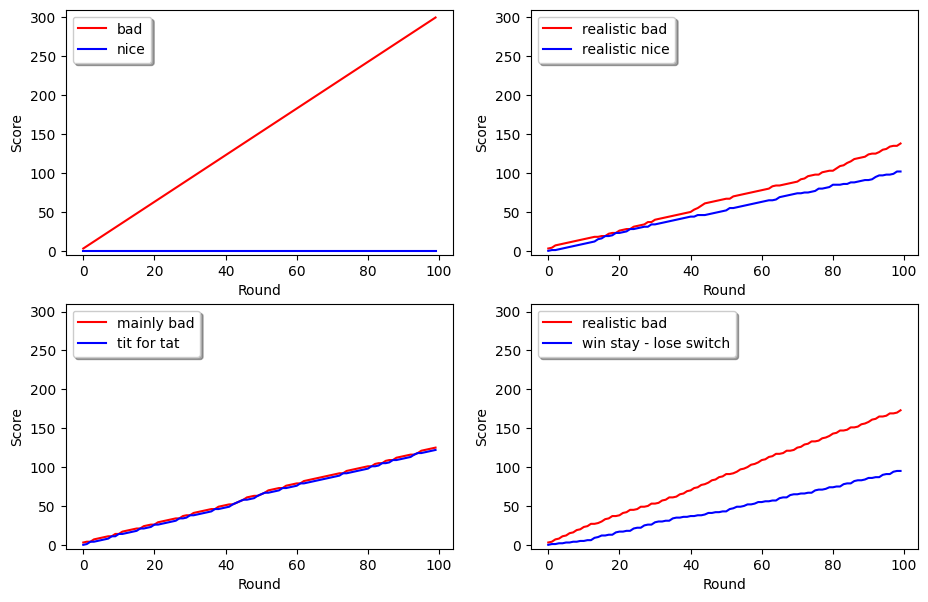

In [4]:
import matplotlib.pyplot as plt
n_rounds = 100

b = Player(strategies, 'bad')
n = Player(strategies, 'nice')
bn = match(b,n,n_rounds,payoff,each=True)

rn = Player(strategies, 'realistic nice')
rb = Player(strategies, 'realistic bad')
rnrb = match(rn,rb,n_rounds,payoff,each=True)

tit = Player(strategies, 'tit for tat')
mb = Player(strategies, 'mainly bad')
tmb = match(tit,mb,n_rounds,payoff,each=True)


rn = Player(strategies, 'realistic bad')
wl = Player(strategies, 'win stay - lose switch')
rnwl = match(rn ,wl,n_rounds,payoff,each=True)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(11, 7))

#fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 5), gridspec_kw={'width_ratios': [0.07, 0.05, 0.05,0.05]})

rounds = np.arange(len(bn))

#legenda sx, x=round,y=score
ylim = 310

ax1.plot(rounds, bn[:,0],label=("bad"),color="red")
ax1.plot(rounds, bn[:,1],label="nice",color="blue")
ax1.legend(loc='upper left', ncol=1, fancybox=True, shadow=True)
ax1.set_xlabel("Round")
ax1.set_ylabel("Score")
ax1.set_ylim(-5,ylim)
ax2.plot(rounds, rnrb[:,1],label=("realistic bad"),color="red")
ax2.plot(rounds, rnrb[:,0],label=("realistic nice"),color="blue")
ax2.set_xlabel("Round")
ax2.set_ylabel("Score")
ax2.set_ylim(-5,ylim)
ax2.legend(loc='upper left', ncol=1, fancybox=True, shadow=True)
ax3.plot(rounds, tmb[:,1],label=("mainly bad"),color="red")
ax3.plot(rounds, tmb[:,0],label=("tit for tat"),color="blue")
ax3.set_xlabel("Round")
ax3.set_ylabel("Score")
ax3.set_ylim(-5,ylim)
ax3.legend(loc='upper left', ncol=1, fancybox=True, shadow=True)
ax4.plot(rounds, rnwl[:,0],label=("realistic bad"),color="red")
ax4.plot(rounds, rnwl[:,1],label=("win stay - lose switch"),color="blue")
ax4.set_xlabel("Round")
ax4.set_ylabel("Score")
ax4.set_ylim(-5,ylim)
ax4.legend(loc='upper left', ncol=1, fancybox=True, shadow=True)
plt.show()
 
#bn[:,0].shape

**Comment on the result.** First of all we can observe that, as expected, bad players obtain a higher score with respect to nice players. On the other hand the tit for tat is able to keep up with the mainly bad, obtaining just a slightly lower score.
Secondly, notice that the trend is roughly linear in each case. This will be an important factor, since we will be able to guess more complex results just from a few rounds.

### Round-robin tournament

We can now study the result of a tournament in which a player of each type takes part and challenges each other player (only once).

In [4]:
n_rounds = 10

# create list of players
players = []

# create a Strategy object for each type of strategy defined and append it to the list of players.
# We obtain one player for each strategy

for name in strategies.keys():   
    players.append(Player(strategies, name))

players = np.array(players)
l = len(players)  # number of different strategies


# cast a Tournament between all strategies in a round-robin scheme (all must face all with no eliminations)

# create 2 tables "subject vs challenger": one with absolute and one with relative score
abs_scores  = np.zeros((l,l))
perc_scores = np.zeros((l,l))

# play one match for each possible combination of players
for i in range(l):
    for j in range(l):

        if j > i:
            points = match(players[i], players[j], n_rounds, payoff)
            tot = np.sum(points)

            abs_scores[i][j]  = points[0]
            abs_scores[j][i]  = points[1]

            perc_scores[i][j] = points[0] / tot
            perc_scores[j][i] = points[1] / tot

# calculate the total score for the tournament for each player
cum_scores = np.sum(abs_scores, axis=1)

# remove the diagonal of the matrix of relative scores (no player plays against another player of the same type
# nor against theirselves)
np.fill_diagonal(perc_scores, np.nan)

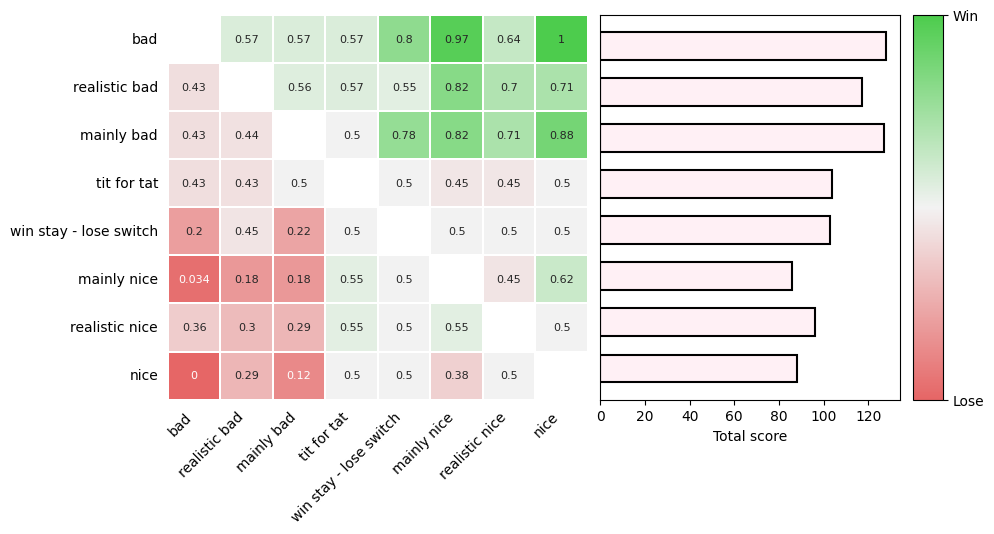

In [6]:
# definisci la colormap personalizzata
colors = [(0.9, 0.4, 0.4), (0.95, 0.95, 0.95), (0.3, 0.8, 0.3)]
cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)

x_labels = []
y_labels = []

for k in strategies.keys():
    x_labels.append(k)
    y_labels.append(k)



# crea una figura con tre subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 5), gridspec_kw={'width_ratios': [0.07, 0.05, 0.005]})

# disegna la matrice di confusione nel primo subplot
sns.heatmap(perc_scores, ax=axs[0], cmap=cmap, annot=True, linewidths=0.01, cbar=False, annot_kws={"fontsize": 8})

# aggiungi etichette, ticks e barra dei colori
axs[0].set_xticklabels(x_labels,rotation=45, ha='right', fontsize=10)
axs[0].set_yticklabels(y_labels,rotation=360, ha='right', fontsize=10)
axs[0].tick_params(left=False)
axs[0].tick_params(bottom=False)

# disegna la somma delle righe nel secondo subplot
# normalizza i valori tra 0 e 1
y = np.arange(perc_scores.shape[0])
axs[1].barh(y[::-1], cum_scores, edgecolor="black",color="lavenderblush",height=0.6,linewidth=1.5)
axs[1].set(yticklabels=[])  
axs[1].tick_params(left=False)
axs[1].set_xlabel("Total score")
axs[1].set_facecolor('xkcd:white')

# aggiungi una barra dei colori nel terzo subplot
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])  # dummy per creare la barra dei colori
cbar = plt.colorbar(sm, cax=axs[2])
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Lose', 'Win'])
cbar.ax.tick_params(labelsize=10)

# aggiusta la posizione dei subplot per evitare sovrapposizioni
plt.subplots_adjust(wspace=0.05)

plt.show()

**Comment on the result.** On the left, the relative score obtained by the players on the column (subjects) when playing against a player on the row (challenger), in a 10-round match, is reported. The sum of cells symmetric with respect to the diagonal is 1.
On the right, total score of each player in all the matches of the tournament. As expected, bad players collect higher scores with respect to nice players. The tit for tat player does not look, in such a heterogeneous population, particularly favoured. Nevertheless notice that they always either lose for a few points or draw against evil players. This will give them an advantage when playing within more complex populations.

# Point 2

We now define a standard _Tournament_ function to perform a series of matches among players which form a more numerous population. We will therefore be able to analyse the system behaviour at different initial population distributions.
We also add a function _create_pop_ to generate a population of players starting from a dictionary of strategies and a vector with probability distribution of each class in the whole population.

In [5]:
# Tournament: return the total score realised by each player during the whole Tournament
def Tournament(strategies, players, n_rounds, payoff):

    # define the vector of scores for each player
    scores = np.zeros(len(players))

    # perform all matches among all players
    for i in range (len(players)):
        for j in range (len(players)):
            
            if i > j:
                # players is a vector of strings, each one being the name of a strategy. We therefore need to create
                # a Player object from the player's name to be able to call the match function
                score_tot =  match(Player(strategies, players[i]),Player(strategies, players[j]), n_rounds, payoff)
                
                # update the scores of both players
                scores[i] += score_tot[0]
                scores[j] += score_tot[1]

    # calculate the cumulative score obtained by each class of players
    cum_scores = []
    
    for name in strategies.keys():
        cum_scores.append(np.sum(scores[players == name]))
        
    cum_scores = np.array(cum_scores)

    # return both the score of each player and the cumulative score obtained by each class of players
    return scores, cum_scores

# create a population according to a given vector with the proportion of players for each strategy
# (distr must have length equal to strategies, and the sum of its cells must be 1)
def create_pop(strategies, distr, n_players, random=True):
    
    # random selection to make it more realistic if random is activated
    if random == True:
        # modify distr to make it a probability distribution
        players = np.random.choice(list(strategies.keys()), n_players, p=distr)

        # also return the population distribution for each type of strategy 
        # (it will be different due to the noise)
        distribution = [list(players).count(j) / n_players for j in strategies.keys()]

        return players, distribution


    else:

        # this time we need the (integer) number of players for each category and not the relative distribution
        distr = np.array(distr)
        distr *= n_players
        distr = distr.astype(int)
        
        # generate the population with the exact number of players required
        players = [name for name, count in zip(strategies.keys(), distr) for _ in range(count)]
 
        players = np.array(players)

        return players
    

We can now perform an MPIPD considering a tournament in which 100 players from all the strategies play against each other in matches of 100 rounds. In particular we define a new dictionary removing the _mainly bad_, the _mainly nice_ and the _win stay - lose switch_. Indeed, the strategies of _mainly nice_ and _mainly bad_ are quite similar to the strategies of _nice_ and _bad_, and they do not rely on memory. Therefore, removing them from the analysis does not alter the significance of the results, but actually makes their interpretation easier. On the other hand, the _win-stay-lose-switch_ strategy is difficult to interpret.

To demonstrate the relationship between the tournament results and the initial population, we have conducted the tournament using different strategies distributions, which are as follows:

- Players distributed in 50% nice and 50% bad.
- Players evenly distributed among the five strategies.
- Players distributed as 5% bad, 5% realistic bad, 30% tit for tat, 30% realistic nice, and 30% nice, with a prevalence of "nice" players.
- Players distributed in 50% tit for tat, 25% bad, and 25% realistic bad.
- Players distributed as 10% bad, 10% realistic bad, 60% tit for tat, 10% realistic nice, and 10% nice, with a prevalence of tit for tat.

In [58]:
# let's choose a reduced set of strategies
characters = {'bad':np.array([0,0,0,0,0]),
              'realistic bad':np.array([0.3,0.1,0.3,0.1,0]),
              'tit for tat':np.array([1,0,1,0,1]),
              'realistic nice':np.array([0.8,0.2,0.8,0.2,1]),
              'nice': np.array([1, 1, 1, 1,1]),                
              }

# Data for the pie chart
labels = [name for name in characters.keys()]

n_rounds = 100
n_players = 100

#create the list of players as string names
distr1 = [0.2, 0.2, 0.2, 0.2, 0.2]
population1, _ = create_pop(characters, distr1, n_players)
_ , scores1 = Tournament(characters, population1, n_rounds, payoff) # save scores by strategy only

distr2 = [0.05, 0.05, 0.3, 0.3, 0.3]
population2, _ = create_pop(characters, distr2, n_players)
_ , scores2 = Tournament(characters, population2, n_rounds, payoff)


# let's choose a reduced set of strategies
characters = {'bad':np.array([0,0,0,0,0]),
              'nice': np.array([1, 1, 1, 1,1])               
              }

distr3 = [0.5, 0.5]
population3, _ = create_pop(characters, distr3,n_players)
_ , scores3 = Tournament(characters, population3, n_rounds, payoff)


# let's choose a reduced set of strategies
characters = {'bad':np.array([0,0,0,0,0]),
              'realistic bad':np.array([0.3,0.1,0.3,0.1,0]),
              'tit for tat':np.array([1,0,1,0,1])         
              }

distr4 = [0.25, 0.25, 0.5]
population4, _ = create_pop(characters, distr4,n_players)
_ , scores4 = Tournament(characters, population4, n_rounds, payoff)


#  set of strategies
characters = {'bad':np.array([0,0,0,0,0]),
              'realistic bad':np.array([0.3,0.1,0.3,0.1,0]),
              'tit for tat':np.array([1,0,1,0,1]),
              'realistic nice':np.array([0.8,0.2,0.8,0.2,1]),
              'nice': np.array([1, 1, 1, 1,1])               
              }

distr5 = [0.1, 0.1, 0.6, 0.1, 0.1]
population5, _ = create_pop(characters, distr5, n_players)
_ , scores5 = Tournament(characters, population5, n_rounds, payoff)

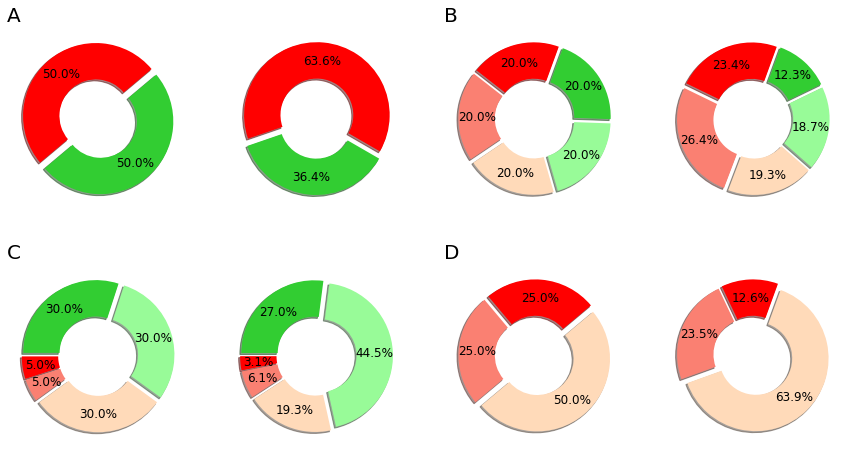

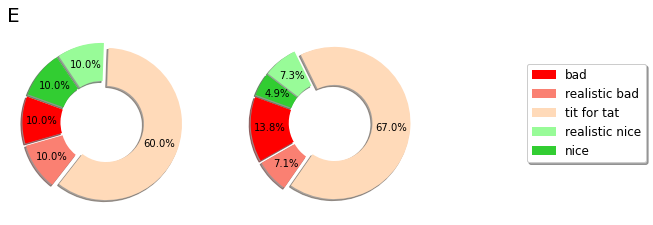

In [59]:

# Create a pie chart
explode1 = (0.05, 0.05, 0.05, 0.05, 0.05)
explode2 = (0.05, 0.05)
explode3 = (0.05, 0.05, 0.05)

fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(figsize = (15,8), nrows = 2, ncols = 4)

ax3.pie(distr1, autopct='%1.1f%%',colors=["red","salmon","peachpuff","palegreen","limegreen"],
        textprops={'fontsize': 12},shadow=True,
        wedgeprops=dict(width=0.5), startangle=70,pctdistance=0.75,
        explode=explode1)
ax3.set_title("B",loc="left",fontsize=20)

ax4.pie(scores1, autopct='%1.1f%%',colors=["red","salmon","peachpuff","palegreen","limegreen"],
        textprops={'fontsize': 12},shadow=True,
        wedgeprops=dict(width=0.5), startangle=70,pctdistance=0.75,
        explode=explode1)


ax5.pie(distr2, autopct='%1.1f%%',colors=["red","salmon","peachpuff","palegreen","limegreen"],
        textprops={'fontsize': 12},shadow=True,
        wedgeprops=dict(width=0.5), startangle=180,pctdistance=0.75,
        explode=explode1)
ax5.set_title("C",loc="left",fontsize=20)

ax6.pie(scores2, autopct='%1.1f%%',colors=["red","salmon","peachpuff","palegreen","limegreen"],
        textprops={'fontsize': 12},shadow=True,
        wedgeprops=dict(width=0.5), startangle=180,pctdistance=0.75,
        explode=explode1)


ax1.pie(distr3,  autopct='%1.1f%%',colors=["red","limegreen"],
        shadow=True, textprops={'fontsize': 12}, wedgeprops=dict(width=0.5), startangle=40,pctdistance=0.75,
        explode=explode2)
ax1.set_title("A",loc="left",fontsize=20)

ax2.pie(scores3, autopct='%1.1f%%',colors=["red","limegreen"],
        textprops={'fontsize': 12},shadow=True,
        wedgeprops=dict(width=0.5), startangle=-30,pctdistance=0.75,
        explode=explode2)


ax7.pie(distr4, autopct='%1.1f%%',colors=["red","salmon","peachpuff"],
        textprops={'fontsize': 12},shadow=True, 
        wedgeprops=dict(width=0.5), startangle=40,pctdistance=0.75,
        explode=explode3)
ax7.set_title("D",loc="left",fontsize=20)

ax8.pie(scores4, autopct='%1.1f%%',colors=["red","salmon","peachpuff"],
        textprops={'fontsize': 12},shadow=True,
        wedgeprops=dict(width=0.5), startangle=70,pctdistance=0.75,
        explode=explode3)


fig, (ax9,ax10) = plt.subplots(figsize = (7.5,7.5), nrows = 1, ncols = 2)

ax9.pie(distr5, autopct='%1.1f%%',colors=["red","salmon","peachpuff","palegreen","limegreen"],
        textprops={'fontsize': 10},shadow=True, 
        wedgeprops=dict(width=0.5), startangle=-200,pctdistance=0.75,
        explode=explode1)
ax9.set_title("E",loc="left",fontsize=20)


ax10.pie(scores5, autopct='%1.1f%%',colors=["red","salmon","peachpuff","palegreen","limegreen"],
         textprops={'fontsize': 10},shadow=True, 
         wedgeprops=dict(width=0.5), startangle=-200,pctdistance=0.75,
        explode=explode1)

plt.legend( ['bad', 'realistic bad',"tit for tat", "realistic nice", "nice"],loc="center left",
           bbox_to_anchor=(1.5,0.55),fontsize=12,fancybox=True, shadow=True)
plt.show()

**Comment on the result.** Starting from a population equally split between nice and bad (A) we observe that after 100 rounds the bad players have collected a much larger amount of points, as expected. The difference this time is that nice players can collect some points while playing with other nice players. Nevertheless if we start from a population equally split into the five different categories (B) the cooperation among nice and tit for tat players doesn't allow bad players to dominate over nice players - indeed,the propotions remain substantial the same. 
Anyway the arrogance of bad players allows them to remain stable even if the initial propotion of the nice players is much higher (C). It is indeed the tit for tat players that hold bad players, thus decreasing their total score (D). \
The presence of a large number of tit for tat players partially preserves the score of the nice players while holding bad players at the same time (E).

# Point 3

After introducing the idea of tournament, we introduce in the scheme the idea of "descendants" of the population. In this way, we can mimic the reproduction of the players involved in the tournament, and see whether a strategy class is going to dominate over the others in the long term, that is the overall population of future generations is composed (mainly) by a single class. 
In order to model such a process, we determine the composition of the children population by means of the total score obtained by each class after a single tournament, as if it were the resources that the class shares.

In this way, differently from what observed before, we may expect that strategies that admit cooperation are going to dominate over the others, since mutual cooperation is more rewarding than mutual defection. Therefore, if the population is sufficiently cooperating, the corresponding classes may emerge more than the ones that tend to defect, since their scores will be greater.

The updating of population can be made in two distinct but similar ways: in the first, the proportions of successors are determined by the relative scores that the classes obtained in the tournament.
In the second we admit the presence of possible noise, and the population is created sampling from the previous players with probability equal to the relative scores.


### Algorithmic implementation

The overall process is made by the function _Evolution_, which takes in input the initial distribution and returns the distribution of the strategies at the end of each repetition of the tournament, for the desired number of iterations. _Evolution_ can admit as argument the noise for probabilistic update of the players after one tournament.

In [24]:
# Evolve the distribution according to the score of the previous tournament
def Evolution(strategies, distr, n_players, n_rounds, payoff, t, noise=True):

    # array with all population distributions at the end of each tournament (matrix)
    distributions = np.array([distr]) # add initial population distribution

    # initial population
    players = create_pop(strategies, distr, n_players, random=False)

    if noise==True:

        for i in range(t):

            # play the tournament and save the 
            _ , cum_scores = Tournament(strategies, players, n_rounds, payoff)

            new_distr = list(cum_scores/np.sum(cum_scores))

            # the new population distribution will be given by the score obtained by every strategy
            # in the previous tournament
            players, distribution = create_pop(strategies, new_distr, n_players, random=noise)

            distributions = np.append(distributions, [np.array(distribution)], axis=0)

        return distributions

    else: 
        for i in range(t):

            # play the tournament and save the 
            _ , cum_scores = Tournament(strategies, players, n_rounds, payoff)

            new_distr = list(cum_scores/np.sum(cum_scores))

            # the new population distribution will be given by the score obtained by every strategy
            # in the previous tournament
            players = create_pop(strategies, new_distr, n_players, random=noise)

            distributions = np.append(distributions, [np.array(new_distr)], axis=0)

        return distributions

All the simulations are run with 200 players, uniformly distributed.

#### 1. All vs All, uniform distribution

In [11]:
characters = {'bad':np.array([0,0,0,0,0]),
              'realistic bad':np.array([0.3,0.1,0.3,0.1,0]),
              'mainly bad':np.array([0.3,0.3,0.3,0.3,0.3]),
              'tit for tat':np.array([1,0,1,0,1]),
              'win stay - lose switch':np.array([1,0,0,1,1]),
              'mainly nice':np.array([0.7,0.7,0.7,0.7,0.7]),
              'realistic nice':np.array([0.8,0.2,0.8,0.2,1]),
              'nice': np.array([1, 1, 1, 1,1]),                
              }


n_rounds = 5
distr = [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
n_players = 200

populations = Evolution(characters, distr, n_players, n_rounds, payoff, t=60)    #run the repeted tournaments, and return the list of players  
                                                                      #at each Tournament

#### 2. All vs All, uniform distribution (repetition 2)

In [12]:
characters2 = {'bad':np.array([0,0,0,0,0]),
              'realistic bad':np.array([0.3,0.1,0.3,0.1,0]),
              'mainly bad':np.array([0.3,0.3,0.3,0.3,0.3]),
              'tit for tat':np.array([1,0,1,0,1]),
              'win stay - lose switch':np.array([1,0,0,1,1]),
              'mainly nice':np.array([0.7,0.7,0.7,0.7,0.7]),
              'realistic nice':np.array([0.8,0.2,0.8,0.2,1]),
              'nice': np.array([1, 1, 1, 1,1]),                
              }


n_rounds2 = 10
distr2 = [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
n_players2 = 200

populations2 = Evolution(characters2, distr2, n_players2, n_rounds2, payoff, t=60)    #run the repeted tournaments, and return the list of players  
                                                                      #at each Tournament

Let's choose a reduced set of strategies.
#### 3. Reduced All vs All, uniform distribution

In [13]:
characters3 = {'bad':np.array([0,0,0,0,0]),
              'realistic bad':np.array([0.3,0.1,0.3,0.1,0]),
              'tit for tat':np.array([1,0,1,0,1]),
              'realistic nice':np.array([0.8,0.2,0.8,0.2,1]),
              'nice': np.array([1, 1, 1, 1,1]),                
              }


n_rounds3 = 10
distr3 = [0.2, 0.2, 0.2, 0.2, 0.2]
n_players3 = 200

populations3 = Evolution(characters3, distr3, n_players3, n_rounds3, payoff, t=60)    #run the repeted tournaments, and return the list of players  


#### 4. Reduced All vs All, uniform distribution (repetition 2)

In [14]:
characters4 = {'bad':np.array([0,0,0,0,0]),
              'realistic bad':np.array([0.3,0.1,0.3,0.1,0]),
              'tit for tat':np.array([1,0,1,0,1]),
              'realistic nice':np.array([0.8,0.2,0.8,0.2,1]),
              'nice': np.array([1, 1, 1, 1,1]),                
              }


n_rounds4 = 10
distr4 = [0.2, 0.2, 0.2, 0.2, 0.2]
n_players4 = 200

populations4 = Evolution(characters4, distr4, n_players4, n_rounds4, payoff, t=60)    #run the repeted tournaments, and return the list of players  


#### 5. Realistic bad, Realistic nice, Tit for Tat, Win stay - Lose switch

In [15]:
characters5 = {
              'realistic bad':np.array([0.3,0.1,0.3,0.1,0]),
              'tit for tat':np.array([1,0,1,0,1]),
              'win stay - lose switch':np.array([1,0,0,1,1]),
              'realistic nice':np.array([0.8,0.2,0.8,0.2,1]),
              }


n_rounds5 = 5
distr5 = [0.25, 0.25, 0.25, 0.25]
n_players5 = 200

populations5 = Evolution(characters5, distr5, n_players5, n_rounds5, payoff, t=60)    #run the repeted tournaments, and return the list of players  
                                                                      #at each Tournament

#### 6. Realistic bad, Realistic nice, Tit for Tat

In [16]:
characters6 = {'realistic bad':np.array([0.3,0.1,0.3,0.1,0]),
              'tit for tat':np.array([1,0,1,0,1]),
              'realistic nice':np.array([0.8,0.2,0.8,0.2,1]),
              }


n_rounds6 = 5
distr6 = [0.34, 0.33, 0.33]
n_players6 = 200

populations6 = Evolution(characters6, distr6, n_players6, n_rounds6, payoff, t=60)    #run the repeted tournaments, and return the list of players  
                                                                      #at each Tournament


### Visualization of the results

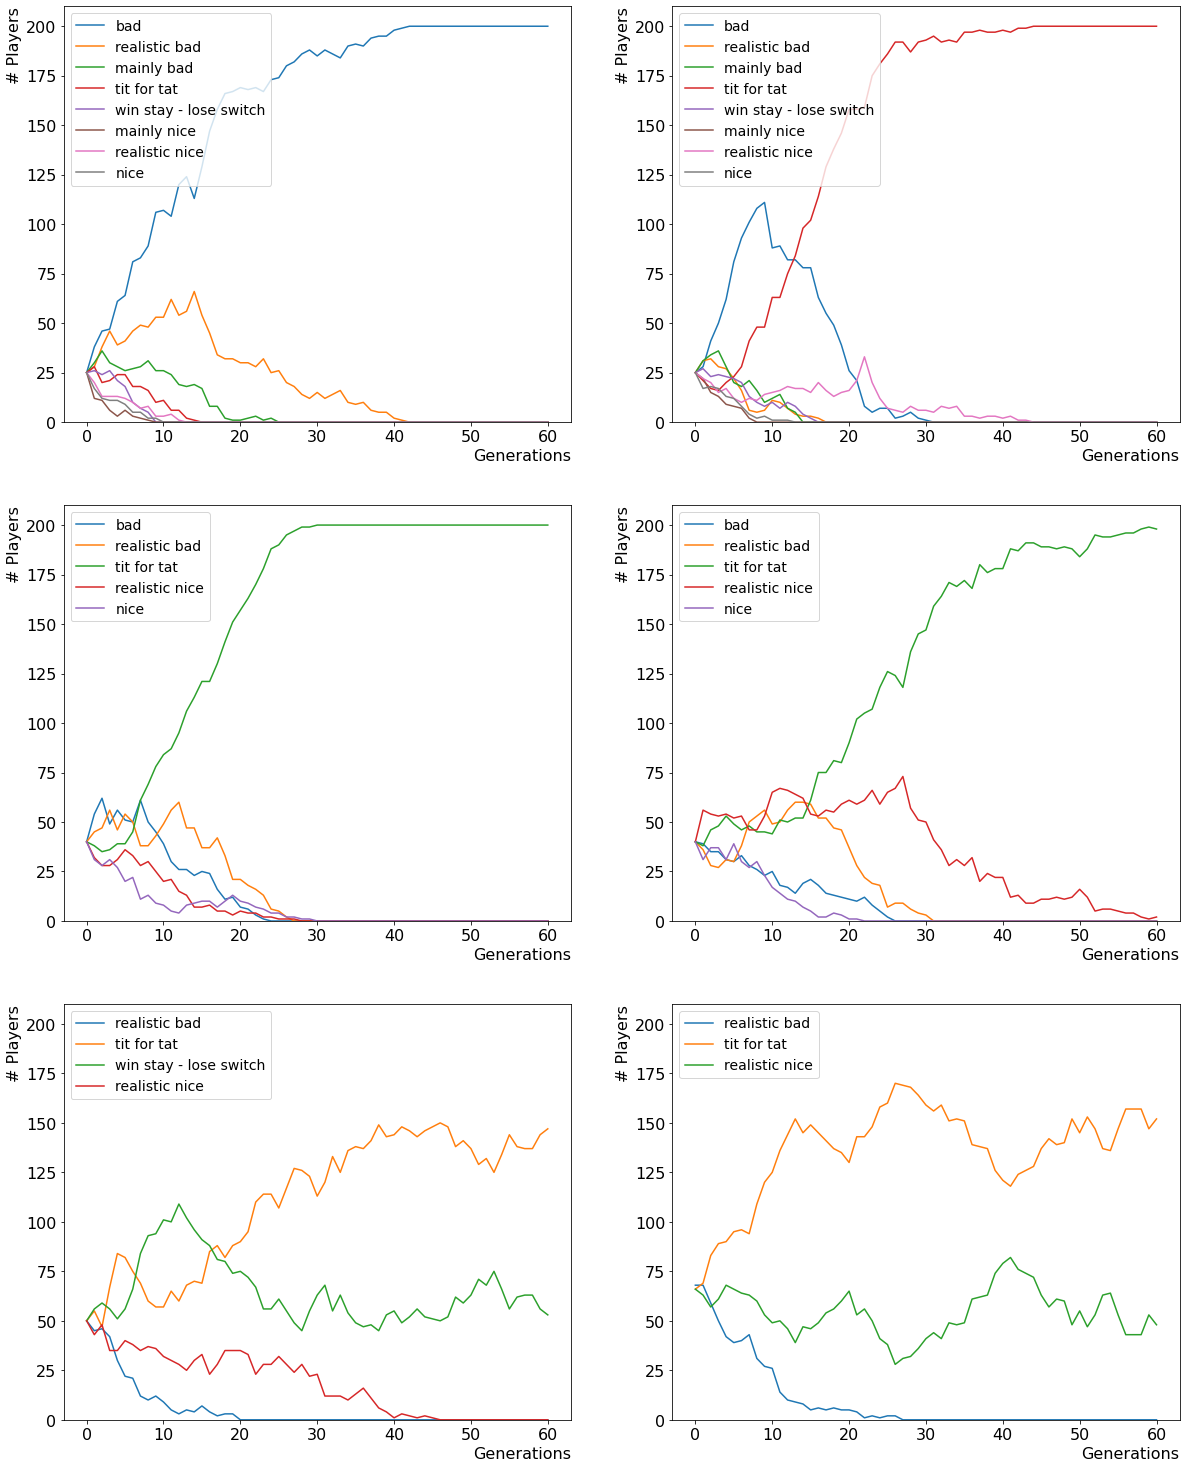

In [17]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20,26))


#ALL VERSUS ALL, UNIFORM

#Plot of generations in time
populations_plt = populations*n_players
populations_plt = populations_plt.astype(int)


for i, nome in zip(range(len(distr)), characters.keys()):
    axs[0,0].plot(np.arange(61), np.array(populations_plt).T[i], label=nome)
    

#ALL VERSUS ALL, UNIFORM 2

#Plot of generations in time
populations_plt2 = populations2*n_players
populations_plt2 = populations_plt2.astype(int)


for i, nome in zip(range(len(distr)), characters.keys()):
    axs[0,1].plot(np.arange(61), np.array(populations_plt2).T[i], label=nome)
    


#REDUCED ALL VS REDUCED ALL, UNIFORM

#Plot of generations in time
populations3_plt = populations3*n_players3
populations3_plt = populations3_plt.astype(int)

for i, nome in zip(range(len(distr3)), characters3.keys()):
    axs[1,0].plot(np.arange(61), np.array(populations3_plt).T[i], label=nome)

    

#REDUCED ALL VS REDUCED ALL, UNIFORM 2

#Plot of generations in time
populations4_plt = populations4*n_players4
populations4_plt = populations4_plt.astype(int)

for i, nome in zip(range(len(distr4)), characters4.keys()):
    axs[1,1].plot(np.arange(61), np.array(populations4_plt).T[i], label=nome)



#REAL NICE, REAL BAD, TIT FOR TAT, WIN STAY LOSE SWITCH

#Plot of generations in time
populations5_plt = populations5 * n_players5
populations5_plt = populations5_plt.astype(int)

for i, nome in zip(range(len(distr5)), characters5.keys()):
    axs[2,0].plot(np.arange(61), np.array(populations5_plt).T[i], label=nome)



#REAL NICE, REAL BAD, TIT FOR TAT

#Plot of generations in time
populations6_plt = populations6 * n_players6
populations6_plt = populations6_plt.astype(int)

for i, nome in zip(range(len(distr6)), characters6.keys()):
    axs[2,1].plot(np.arange(61), np.array(populations6_plt).T[i], label=nome)


    
for i in range(3):
    for j in range(2):
        axs[i,j].set_ylim(0,210)
        axs[i,j].set_xlabel('Generations', loc='right', fontsize=16)
        axs[i,j].set_ylabel('# Players', loc='top', fontsize=16)
        axs[i,j].tick_params(labelsize=16)
        axs[i,j].legend(fontsize=14, loc='upper left')
        

***Comments on the result***

As can be seen in the above plots, the dominant strategy (in case one emerges) after repeted iterations of the tournament is largely dependent on the composition of the initial population. In particular, the Tit-for-Tat strategy will not be as successful as in the previous point, because here the presence of multiple copies of each strategy make it easy for defecting players to score more points when matching against the nice ones.

Therefore, we performed multiple tests starting from different populations uniformly distributed at the beginning. With uniform initial distributions, different final scenarios are plausible, the reasons being that part of the strategies are non-deterministic, and because of the noise introduced at every update of the population. This further randomness can significantly alter the composition of the next generation, potentially lowering powerful strategies.

In the second row we show a more realistic subset of strategies (without purely nice or bad players): we can observe that, even if not obvious, the Tit-for-Tat strategy is often a good one, that tends to dominate in a population that doens't admit too much naively good players.


#### 7. Bad, Nice (1-99) no noise

In [28]:
characters7 = {'bad':np.array([0,0,0,0,0]),
              'nice': np.array([1, 1, 1, 1,1]),                
              }


n_rounds7 = 5
distr7 = [0.01, 0.99]
n_players7 = 200

populations7 = Evolution(characters7, distr7, n_players7, n_rounds7, payoff, t=20)    #run the repeted tournaments, and return the list of players  
                                                                      #at each Tournament


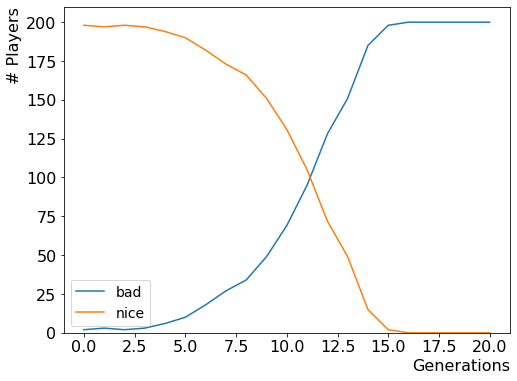

In [30]:
fig, axs = plt.subplots(figsize=(8,6))


#ALL VERSUS ALL, UNIFORM

#Plot of generations in time
populations_plt7 = populations7*n_players7
populations_plt7 = populations_plt7.astype(int)


for i, nome in zip(range(len(distr7)), characters7.keys()):
    axs.plot(np.arange(21), np.array(populations_plt7).T[i], label=nome)
    
axs.set_ylim(0,210)
axs.set_xlabel('Generations', loc='right', fontsize=16)
axs.set_ylabel('# Players', loc='top', fontsize=16)
axs.tick_params(labelsize=16)
axs.legend(fontsize=14, loc='best');


**Comment on the results**

Moreover, with the last plot, we see that being altruistic is not a sufficient characteristic for emerging strategies in this scheme, even when exaggerating non uniform initial conditions: winning strategies must also be retaliating, meaning that they can defect in the case the other player defected in the previous round.

In particular, for the extreme case of deterministic strategies in the extremes of the spectrum (that is bad vs. nice players), for the chosen exact updating, there is no possible initial proportions between the two strategies such that nice players can emerge.

# Point 4

In the final part of our project we have implemented the rMIPD presented in point 3 for populations where the different strategies are allowed to mutate when a new generation of players is created. Here a new concept of strategies is considered since they do not refer anymore to a given list of possible "discrete" choices but their behaviuor is encoded into a set of parameter which are allowed to vary in a continous way. This allows the model to simulate a population where players are described by a gene which, being permitted to mutate randomly, can be used to determine the best-fitted strategy, simulating a process of natural selection.
In our model such a gene is represented by an array containing the four cooperation probabilities $P= \{ P_{cc},P_{cd}, P_{dc}, P_{dd} \} $ such that, concerning statistical results, every memory-n strategy can be reproduced. Moreover a continuos variation of such a gene allows the model to create completely new strategies, consenting to investigate new possibilities out of the so far presented "discrete" strategies.  

The mutation process is simulated by varying randomly each of the four cooperation probabilities. In particular a small, normally distributed     variation is generated and applied to the initial probabilities so that the mutated strategy does not vary too much from the initial one, simulating a real genetic mutation.

Simulations have then been performed following the structures of tournament and evolution presented in previous point with the only difference that the population is now allowed to mutate at each evolution step and that strategies are different for each player.

### Algorithm basis implementation
We implement a function _mutate_ that creates a gaussian mutation for each of the probabilities cointained in the probability vector $P$. Moreover we redefine the functions for the tournament, for the evolution and to create the population, such to be able to deal with the new data structure.

In [15]:
# change the probabilities that define the strategy of each player by means of a mutation
def mutate(players, amount=0.001):

    # gaussian mutation
    mutation = np.around(np.random.normal(loc=0, scale=amount, size=(players.shape[0],players.shape[1])))

    # superimpose the mutation on the probabilities and check that they do not exceed 0 or 1
    mut_players = np.add(players, mutation)
    mut_players[mut_players > 1] = 1
    mut_players[mut_players < 0] = 0

    return mut_players 

# new definition of tournament: no more defined strategies
def Tournament_cont(players, n_rounds, payoff):

    n_players = players.shape[0]

    scores = np.zeros(n_players)

    for i in range (n_players):
        for j in range (n_players):
            if i>j:    
                score_tot =  match(Strategy(players[i]),Strategy(players[j]), n_rounds, payoff)
                scores[i] += score_tot[0]
                scores[j] += score_tot[1]

    return scores

     

# create a population according to a given vector with the number of players for each strategy
def create_pop_cont(strategies, distr):
    
    # with noise to make it more realistic
    players = strategies[np.random.choice(strategies.shape[0], size=strategies.shape[0], p=distr)]


    return players
    
 
def calc_distr(players):
    
    distr = [0,0,0,0,0]
    distr[0] = len(players[np.logical_and.reduce((players[:,0]<0.5,     #Bad
                                                                players[:,1]<0.5, 
                                                                players[:,2]<0.5,
                                                                players[:,3]<0.5,
                                                                players[:,4]<0.5))])

    distr[1] = len(players[np.logical_and.reduce((players[:,0]>=0.5,     #Opportunist
                                                                players[:,1]<0.5, 
                                                                players[:,2]<0.5,
                                                                players[:,3]<0.5,
                                                                players[:,4]<0.5))])

    distr[2] = len(players[np.logical_and.reduce((players[:,0]>=0.5,     #Tit for Tat
                                                                players[:,1]<0.5, 
                                                                players[:,2]>=0.5,
                                                                players[:,3]<0.5,
                                                                players[:,4]>=0.5))])

    distr[3] = len(players[np.logical_and.reduce((players[:,0]>=0.5,     #Nice
                                                                players[:,1]>=0.5, 
                                                                players[:,2]>=.5,
                                                                players[:,3]>=0.5,
                                                                players[:,4]>=0.5))])
            
            # all other players
    distr[4] = len(players) - (distr[0] + distr[1] + distr[2] + distr[3])
    return distr



#Evolve the distribution according to the score of the previous tournament
def Evolution_cont(players, n_rounds, payoff, t, mut=True, mut_amount=0.001, ranges=True):


    distr_ranges = []
    distr_ranges.append(calc_distr(players))

    for i in range(t):

        # play the tournament and save the scores
        scores = Tournament_cont(players, n_rounds, payoff)

        # partial score of each player
        new_distr = list(scores/np.sum(scores))

        # the new population distribution will be given by the score obtained by every strategy
        # in the previous tournament
        players = create_pop_cont(players, new_distr)

        # apply the mutation
        if mut == True:
            players = mutate(players, mut_amount)

        # we also want to see the trend in time of 4 symplifying categories: bad, opportunist, tit for tat, nice
        if ranges == True:
            distr_range = calc_distr(players)
            distr_ranges.append(distr_range)

    distr_ranges = np.array(distr_ranges)
    
    if ranges == True:
    
        # return the new population of players and the vector of the four   matrix at the end of the evolution
        return players, distr_ranges
    
    else:
        return players

### Random initial distribution

As in previous points, also in these simulatins the outcomes will strongly depend on the initial populations, so that several runs have been performed considering different initial strategies distributions.

Firstly a completely randomic population have been considered. In particular in such a population the cooperation probabilities, will be distributed around a mean value of 0.5 independently of the result of the previous round. A histogram of the such created initial population is reported together with the result of the such performed simulation, at different numbers of steps.

In [26]:
n_players = 100
n_rounds = 5

players_norm = np.around(np.random.normal(loc=0.5, scale=0.25, size=(n_players,5)), decimals=2)
players_norm[:][players_norm[:]>1]=1
players_norm[:][players_norm[:]<0]=0

result_norm10 = Evolution_cont(players_norm, n_rounds, payoff, 15, mut=False, ranges = False)
result_norm20 = Evolution_cont(result_norm10, n_rounds, payoff, 15, mut=False, ranges = False)
result_norm30 = Evolution_cont(result_norm20, n_rounds, payoff, 15, mut=False, ranges = False)


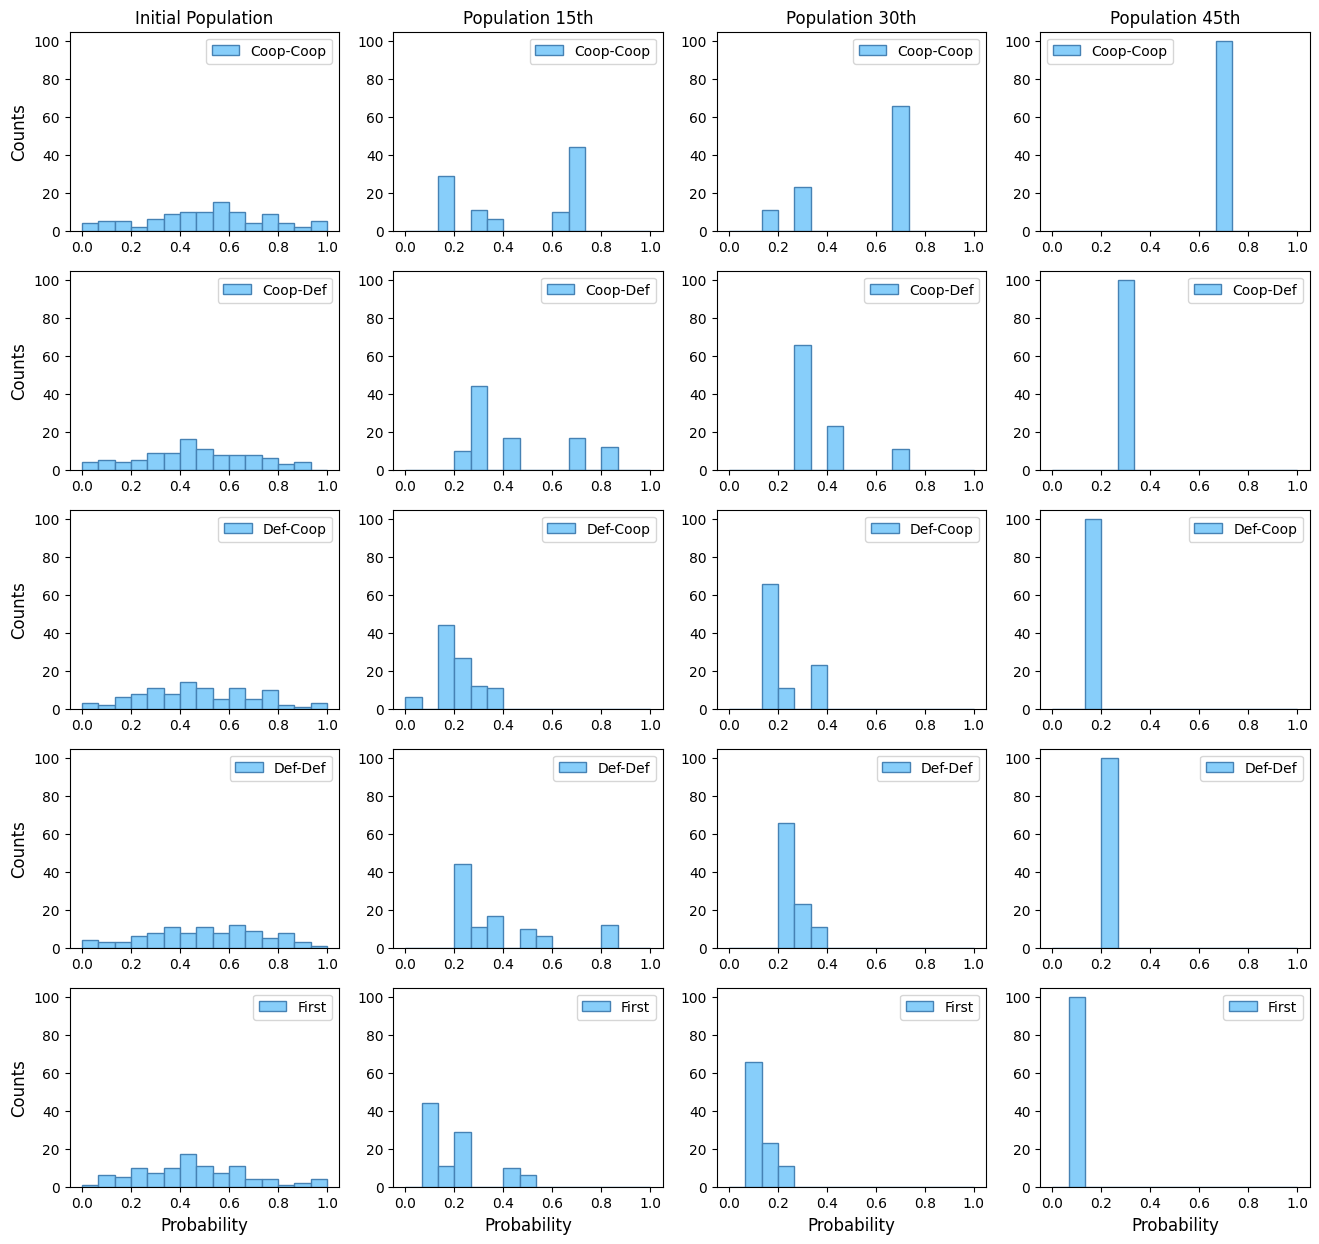

In [31]:
ylim = 105

fig1, axs1 = plt.subplots(nrows=5, ncols=4, figsize=(16, 15))


axs1[0,0].hist(players_norm[:,0], label='Coop-Coop', range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[0,0].set_ylabel('Counts',fontsize=12)
axs1[0,0].set_ylim((0, ylim))
axs1[0,0].set_title('Initial Population',fontsize=12)
axs1[1,0].hist(players_norm[:,1], label='Coop-Def' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[1,0].set_ylim((0, ylim))
axs1[1,0].set_ylabel('Counts',fontsize=12)
axs1[2,0].hist(players_norm[:,2], label='Def-Coop' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[2,0].set_ylim((0, ylim))
axs1[2,0].set_ylabel('Counts',fontsize=12)
axs1[3,0].hist(players_norm[:,3], label='Def-Def' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[3,0].set_ylim((0, ylim))
axs1[3,0].set_ylabel('Counts',fontsize=12)
axs1[4,0].hist(players_norm[:,4], label='First' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[4,0].set_xlabel('Probability',fontsize=12)
axs1[4,0].set_ylim((0, ylim))
axs1[4,0].set_ylabel('Counts',fontsize=12)
axs1[0,0].legend()
axs1[1,0].legend()
axs1[2,0].legend()
axs1[3,0].legend()
axs1[4,0].legend()


axs1[0,1].hist(result_norm10[:,0], label='Coop-Coop', range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[0,1].set_ylim((0, ylim))
axs1[0,1].set_title('Population 15th',fontsize=12)
axs1[1,1].hist(result_norm10[:,1], label='Coop-Def' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[1,1].set_ylim((0, ylim))
axs1[2,1].hist(result_norm10[:,2], label='Def-Coop' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[2,1].set_ylim((0, ylim))
axs1[3,1].hist(result_norm10[:,3], label='Def-Def' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[3,1].set_ylim((0, ylim))
axs1[4,1].hist(result_norm10[:,4], label='First' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[4,1].set_xlabel('Probability',fontsize=12)
axs1[4,1].set_ylim((0, ylim))
axs1[0,1].legend()
axs1[1,1].legend()
axs1[2,1].legend()
axs1[3,1].legend()
axs1[4,1].legend()

axs1[0,2].hist(result_norm20[:,0], label='Coop-Coop', range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[0,2].set_ylim((0, ylim))
axs1[0,2].set_title('Population 30th',fontsize=12)
axs1[1,2].hist(result_norm20[:,1], label='Coop-Def' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[1,2].set_ylim((0, ylim))
axs1[2,2].hist(result_norm20[:,2], label='Def-Coop' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[2,2].set_ylim((0, ylim))
axs1[3,2].hist(result_norm20[:,3], label='Def-Def' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[3,2].set_ylim((0, ylim))
axs1[4,2].hist(result_norm20[:,4], label='First' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[4,2].set_xlabel('Probability',fontsize=12)
axs1[4,2].set_ylim((0, ylim))
axs1[0,2].legend()
axs1[1,2].legend()
axs1[2,2].legend()
axs1[3,2].legend()
axs1[4,2].legend()

axs1[0,3].hist(result_norm30[:,0], label='Coop-Coop', range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[0,3].set_ylim((0, ylim))
axs1[0,3].set_title('Population 45th',fontsize=12)
axs1[1,3].hist(result_norm30[:,1], label='Coop-Def' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[1,3].set_ylim((0, ylim))
axs1[2,3].hist(result_norm30[:,2], label='Def-Coop' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[2,3].set_ylim((0, ylim))
axs1[3,3].hist(result_norm30[:,3], label='Def-Def' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[3,3].set_ylim((0, ylim))
axs1[4,3].hist(result_norm30[:,4], label='First' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[4,3].set_xlabel('Probability',fontsize=12)
axs1[4,3].set_ylim((0, ylim))
axs1[0,3].legend()
axs1[1,3].legend()
axs1[2,3].legend()
axs1[3,3].legend()
axs1[4,3].legend()

plt.show()


**Comment on the result.** We observe that, as time passes, for each probability a clear peak emerges. In particular, the average player seems to be: quite collaborative if the challenger has been collaborative (high $p_1$), quite forgiving if has collaborated but the challenger has not (not too small $p_2$), continues not to collaborate if they have both defected ($p_4$), not particularly generous at the first step ($p_5$) and, most interestingly, opportunist (low $p_3$).


A random simulation considering a uniform distriution of the cooperation probabilities was performed as well.

In [36]:
n_players = 100
n_rounds = 10

players_unif = np.around(np.random.uniform(0,1, size=(n_players, 5)), decimals=2)
players_unif[:][players_unif[:]>1]=1
players_unif[:][players_unif[:]<0]=0

result_unif10 = Evolution_cont(players_unif, n_rounds, payoff, 15, mut=False, ranges=False)
result_unif20 = Evolution_cont(result_unif10, n_rounds, payoff, 15, mut=False, ranges=False)
result_unif30 = Evolution_cont(result_unif20, n_rounds, payoff, 15, mut=False, ranges=False)

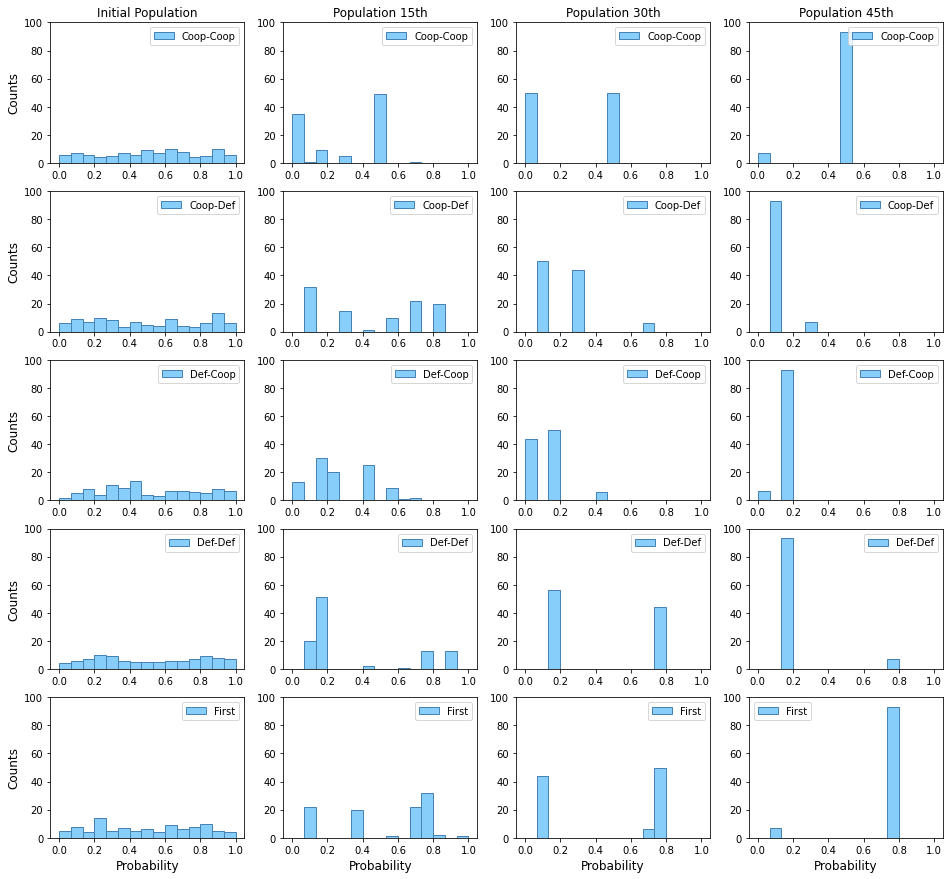

In [37]:
ylim = 100

fig1, axs1 = plt.subplots(nrows=5, ncols=4, figsize=(16, 15))


axs1[0,0].hist(players_unif[:,0], label='Coop-Coop', range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[0,0].set_ylabel('Counts',fontsize=12)
axs1[0,0].set_ylim((0, ylim))
axs1[0,0].set_title('Initial Population',fontsize=12)
axs1[1,0].hist(players_unif[:,1], label='Coop-Def' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[1,0].set_ylim((0, ylim))
axs1[1,0].set_ylabel('Counts',fontsize=12)
axs1[2,0].hist(players_unif[:,2], label='Def-Coop' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[2,0].set_ylim((0, ylim))
axs1[2,0].set_ylabel('Counts',fontsize=12)
axs1[3,0].hist(players_unif[:,3], label='Def-Def' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[3,0].set_ylim((0, ylim))
axs1[3,0].set_ylabel('Counts',fontsize=12)
axs1[4,0].hist(players_unif[:,4], label='First' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[4,0].set_xlabel('Probability',fontsize=12)
axs1[4,0].set_ylim((0, ylim))
axs1[4,0].set_ylabel('Counts',fontsize=12)
axs1[0,0].legend()
axs1[1,0].legend()
axs1[2,0].legend()
axs1[3,0].legend()
axs1[4,0].legend()


axs1[0,1].hist(result_unif10[:,0], label='Coop-Coop', range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[0,1].set_ylim((0, ylim))
axs1[0,1].set_title('Population 15th',fontsize=12)
axs1[1,1].hist(result_unif10[:,1], label='Coop-Def' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[1,1].set_ylim((0, ylim))
axs1[2,1].hist(result_unif10[:,2], label='Def-Coop' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[2,1].set_ylim((0, ylim))
axs1[3,1].hist(result_unif10[:,3], label='Def-Def' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[3,1].set_ylim((0, ylim))
axs1[4,1].hist(result_unif10[:,4], label='First' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[4,1].set_xlabel('Probability',fontsize=12)
axs1[4,1].set_ylim((0, ylim))
axs1[0,1].legend()
axs1[1,1].legend()
axs1[2,1].legend()
axs1[3,1].legend()
axs1[4,1].legend()

axs1[0,2].hist(result_unif20[:,0], label='Coop-Coop', range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[0,2].set_ylim((0, ylim))
axs1[0,2].set_title('Population 30th',fontsize=12)
axs1[1,2].hist(result_unif20[:,1], label='Coop-Def' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[1,2].set_ylim((0, ylim))
axs1[2,2].hist(result_unif20[:,2], label='Def-Coop' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[2,2].set_ylim((0, ylim))
axs1[3,2].hist(result_unif20[:,3], label='Def-Def' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[3,2].set_ylim((0, ylim))
axs1[4,2].hist(result_unif20[:,4], label='First' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[4,2].set_xlabel('Probability',fontsize=12)
axs1[4,2].set_ylim((0, ylim))
axs1[0,2].legend()
axs1[1,2].legend()
axs1[2,2].legend()
axs1[3,2].legend()
axs1[4,2].legend()

axs1[0,3].hist(result_unif30[:,0], label='Coop-Coop', range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[0,3].set_ylim((0, ylim))
axs1[0,3].set_title('Population 45th',fontsize=12)
axs1[1,3].hist(result_unif30[:,1], label='Coop-Def' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[1,3].set_ylim((0, ylim))
axs1[2,3].hist(result_unif30[:,2], label='Def-Coop' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[2,3].set_ylim((0, ylim))
axs1[3,3].hist(result_unif30[:,3], label='Def-Def' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[3,3].set_ylim((0, ylim))
axs1[4,3].hist(result_unif30[:,4], label='First' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[4,3].set_xlabel('Probability',fontsize=12)
axs1[4,3].set_ylim((0, ylim))
axs1[0,3].legend()
axs1[1,3].legend()
axs1[2,3].legend()
axs1[3,3].legend()
axs1[4,3].legend()

plt.show()

**Comment on the result.** In this case the average player shows the same features it showed in the case of an initial population normally distributed (Opportunist).

In any case notice that different simulations can bring to results quite different one from another.


### Activated mutation
We can repeat the simulation adding different amounts of mutation, which is obtained by modifying the five probabilities , at the end of each tuornament, according to a normal distribution of varying standard deviation.



In [42]:
n_players = 100
n_rounds = 10

players_unif_mut = np.random.uniform(0.,1., size=(n_players, 5))
players_unif_mut[:][players_unif_mut[:]>1]=1
players_unif_mut[:][players_unif_mut[:]<0]=0


result_unif_mut10 = Evolution_cont(players_unif_mut, n_rounds, payoff, 15, ranges = False)  #Not specifying mut is 0.001
result_unif_mut20 = Evolution_cont(result_unif_mut10, n_rounds, payoff, 15, ranges = False)
result_unif_mut30 = Evolution_cont(result_unif_mut20, n_rounds, payoff, 15, ranges = False)

In [43]:
result_unif_mut10_2 = Evolution_cont(players_unif_mut, n_rounds, payoff, 15, 0.01,  ranges = False)  #Not specifying mut is 0.001
result_unif_mut20_2 = Evolution_cont(result_unif_mut10_2, n_rounds, payoff, 15,0.01, ranges = False)
result_unif_mut30_2 = Evolution_cont(result_unif_mut20_2, n_rounds, payoff, 15,0.01, ranges = False)

In [44]:
result_unif_mut10_3 = Evolution_cont(players_unif_mut, n_rounds, payoff, 15, 0.1,  ranges = False)  #Not specifying mut is 0.001
result_unif_mut20_3 = Evolution_cont(result_unif_mut10_3, n_rounds, payoff, 15,0.1, ranges = False)
result_unif_mut30_3 = Evolution_cont(result_unif_mut20_3, n_rounds, payoff, 15,0.1, ranges = False)

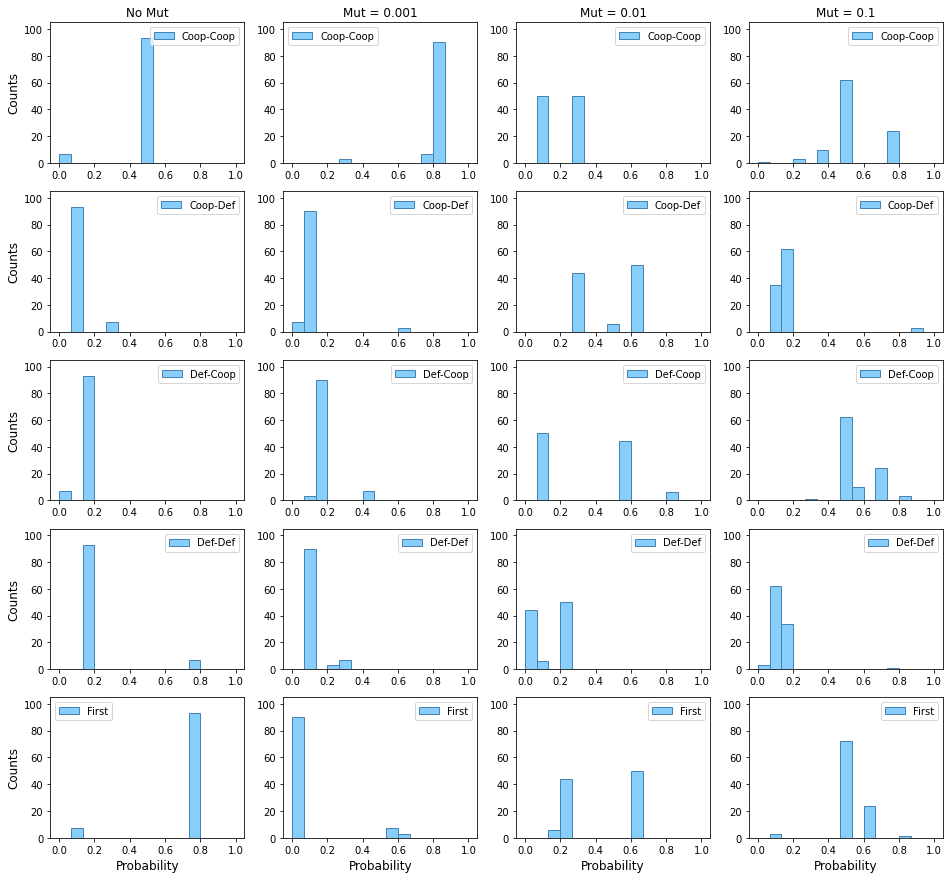

In [45]:
ylim = 105

fig1, axs1 = plt.subplots(nrows=5, ncols=4, figsize=(16, 15))


axs1[0,0].hist(result_unif30[:,0], label='Coop-Coop', range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[0,0].set_ylim((0, ylim))
axs1[0,0].set_title('No Mut',fontsize=12)
axs1[0,0].set_ylabel('Counts',fontsize=12)
axs1[1,0].hist(result_unif30[:,1], label='Coop-Def' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[1,0].set_ylim((0, ylim))
axs1[1,0].set_ylabel('Counts',fontsize=12)
axs1[2,0].hist(result_unif30[:,2], label='Def-Coop' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[2,0].set_ylim((0, ylim))
axs1[2,0].set_ylabel('Counts',fontsize=12)
axs1[3,0].hist(result_unif30[:,3], label='Def-Def' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[3,0].set_ylim((0, ylim))
axs1[3,0].set_ylabel('Counts',fontsize=12)
axs1[4,0].hist(result_unif30[:,4], label='First' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[4,0].set_xlabel('Probability',fontsize=12)
axs1[4,0].set_ylim((0, ylim))
axs1[4,0].set_ylabel('Counts',fontsize=12)
axs1[0,0].legend()
axs1[1,0].legend()
axs1[2,0].legend()
axs1[3,0].legend()
axs1[4,0].legend()


axs1[0,1].hist(result_unif_mut30[:,0], label='Coop-Coop', range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[0,1].set_ylim((0, ylim))
axs1[0,1].set_title('Mut = 0.001',fontsize=12)
axs1[1,1].hist(result_unif_mut30[:,1], label='Coop-Def' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[1,1].set_ylim((0, ylim))
axs1[2,1].hist(result_unif_mut30[:,2], label='Def-Coop' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[2,1].set_ylim((0, ylim))
axs1[3,1].hist(result_unif_mut30[:,3], label='Def-Def' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[3,1].set_ylim((0, ylim))
axs1[4,1].hist(result_unif_mut30[:,4], label='First' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[4,1].set_xlabel('Probability',fontsize=12)
axs1[4,1].set_ylim((0, ylim))
axs1[0,1].legend()
axs1[1,1].legend()
axs1[2,1].legend()
axs1[3,1].legend()
axs1[4,1].legend()

axs1[0,2].hist(result_unif_mut30_2[:,0], label='Coop-Coop', range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[0,2].set_ylim((0, ylim))
axs1[0,2].set_title('Mut = 0.01',fontsize=12)
axs1[1,2].hist(result_unif_mut30_2[:,1], label='Coop-Def' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[1,2].set_ylim((0, ylim))
axs1[2,2].hist(result_unif_mut30_2[:,2], label='Def-Coop' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[2,2].set_ylim((0, ylim))
axs1[3,2].hist(result_unif_mut30_2[:,3], label='Def-Def' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[3,2].set_ylim((0, ylim))
axs1[4,2].hist(result_unif_mut30_2[:,4], label='First' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[4,2].set_xlabel('Probability',fontsize=12)
axs1[4,2].set_ylim((0, ylim))
axs1[0,2].legend()
axs1[1,2].legend()
axs1[2,2].legend()
axs1[3,2].legend()
axs1[4,2].legend()

axs1[0,3].hist(result_unif_mut30_3[:,0], label='Coop-Coop', range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[0,3].set_ylim((0, ylim))
axs1[0,3].set_title('Mut = 0.1',fontsize=12)
axs1[1,3].hist(result_unif_mut30_3[:,1], label='Coop-Def' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[1,3].set_ylim((0, ylim))
axs1[2,3].hist(result_unif_mut30_3[:,2], label='Def-Coop' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[2,3].set_ylim((0, ylim))
axs1[3,3].hist(result_unif_mut30_3[:,3], label='Def-Def' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[3,3].set_ylim((0, ylim))
axs1[4,3].hist(result_unif_mut30_3[:,4], label='First' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs1[4,3].set_xlabel('Probability',fontsize=12)
axs1[4,3].set_ylim((0, ylim))
axs1[0,3].legend()
axs1[1,3].legend()
axs1[2,3].legend()
axs1[3,3].legend()
axs1[4,3].legend()

plt.show()

**Comment on the result.** We can observe that as the mutation amount increases the result appears to be less stable. In particular, it seems to divide into two separated peaks, which means that more strategies are likely to cohabit.

Moreover, as the mutation amount increases, random effects are emphasized, leading to more aggressive or more tit-for-tat-like survivors. 

### Grouping by leading categories
In next section players were grouped into four subgroups of similar strategies for result visualization purposes. Such four ranges have been thought as to represent the most logical and basic strategies, according to the so far emerged results, which indeed are _bad, nice, tit for tat_ and _opportunist_. The latter is similar to tit for tat with the difference that when they defected and their opponent cooperated, they will tend to defect again to take advantage from the opponent's loyalty. 

Further simulations were performed considering as initial population a distribution of players belonging to each of the four strategy ranges. In particular in this case a player belonging to a given category is obtained from random cooperation probabilities which are normally distributed around a given reference strategy. For example a player which refers to the category Nice will have all of the four cooperation probabilities taken from a normal ditribution peaked at 0.75, and so on.

We add a function _create_pop_ranges_ that creates the initial population in the aforementioned manner.

In [19]:

def create_pop_ranges(strategies, distr, scale = 0.05):
    players = []
    for name,count in zip(strategies.keys(), distr):
        for j in range(count):
            player = []
            for k in range(5):
                player.append(np.random.normal(loc = strategies[name][k],scale = scale ))

            player_f = np.array(player)
            player_f[player_f>1]=1
            player_f[player_f<0]=0
            players.append(player_f)    
    players = np.array(players)
    distr_f = calc_distr(players)
    return players, distr_f


We created a dictionary containig the mentioned four categories, and run the evolution function with a small mutation activated.

In [21]:
characters_range = {'bad':np.array([0.25,0.25,0.25,0.25,0.25]), 
                    'opportunist':np.array([0.75,0.25,0.25,0.25,0.25]),
                    'tit fot tat':np.array([0.75,0.25,0.75,0.25,0.75]),
                    'nice':np.array([0.75,0.75,0.75,0.75,0.75])}

distr_ranges_init = [50,50,50,50]

players_ranges, _ = create_pop_ranges(characters_range, distr_ranges_init)

In [22]:
result_ranges, r_distributions_ranges = Evolution_cont(players_ranges, n_rounds, payoff, 30)

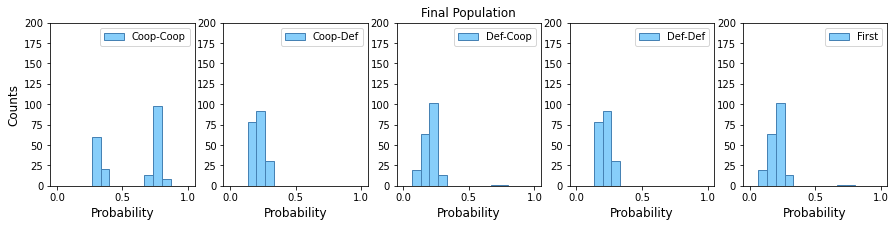

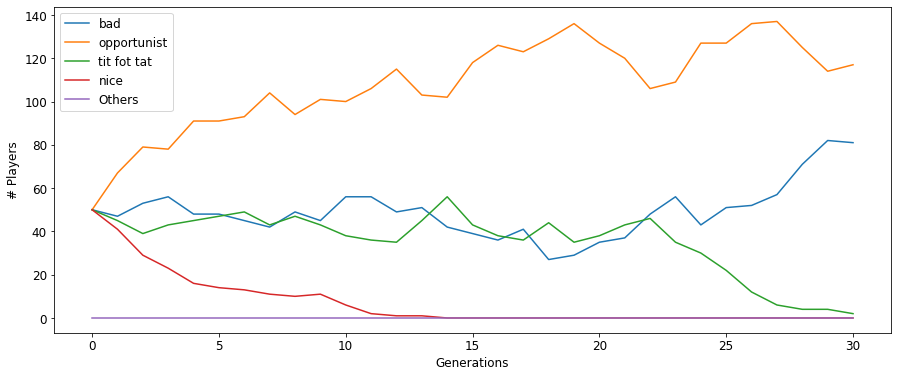

In [27]:
ylim = 200

fig3_a, axs3a = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))


axs3a[0].hist(result_ranges[:,0], label='Coop-Coop', range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs3a[0].set_ylim((0, ylim))
axs3a[0].set_ylabel('Counts',fontsize=12)
axs3a[0].set_xlabel('Probability',fontsize=12)
axs3a[1].hist(result_ranges[:,1], label='Coop-Def', range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs3a[1].set_ylim((0, ylim))
axs3a[1].set_xlabel('Probability',fontsize=12)
axs3a[2].hist(result_ranges[:,2], label='Def-Coop', range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs3a[2].set_ylim((0, ylim))
axs3a[2].set_xlabel('Probability',fontsize=12)
axs3a[2].set_title('Final Population',fontsize=12)
axs3a[3].hist(result_ranges[:,1], label='Def-Def' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs3a[3].set_ylim((0, ylim))
axs3a[3].set_xlabel('Probability',fontsize=12)
axs3a[4].hist(result_ranges[:,2], label='First' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs3a[4].set_ylim((0, ylim))
axs3a[4].set_xlabel('Probability',fontsize=12)
axs3a[0].legend()
axs3a[1].legend()
axs3a[2].legend()
axs3a[3].legend()
axs3a[4].legend()


fig3_b, axs3_b = plt.subplots(figsize = (15,6))

for i, nome in zip(range(len(distr_ranges_init)), characters_range.keys()):
    axs3_b.plot(np.arange(31), np.array(r_distributions_ranges).T[i], label=nome)
axs3_b.plot(np.arange(31),np.array(r_distributions_ranges).T[4], label = 'Others')

axs3_b.set_xlabel('Generations',fontsize=12)
axs3_b.set_ylabel('# Players',fontsize=12)
axs3_b.tick_params(labelsize=12)
axs3_b.legend(fontsize = 12)

plt.show()


As expected, The opportunist category results again to be the winner in such a population. The small amount of mutation does not allow players out of these four categories (_Others_) to emerge. 

Finally, populations with cooperation probabilities closer to reference strategies have been considered.

In [63]:
# Definition of more peaked strategy ranges
characters_range_peak = {'bad':np.array([0.2,0.2,0.2,0.2,0.2]), 
                         'opportunist':np.array([0.8,0.2,0.2,0.2,0.2]),
                         'tit fot tat':np.array([1,0,1,0,1]),
                         'nice':np.array([0.8,0.8,0.8,0.8,0.8])}

distr_peak_init = [50,50,50,50]

players_peak, _ = create_pop_ranges(characters_range_peak, distr_peak_init)

In [64]:
result_peak, r_distributions_peak = Evolution_cont(players_peak, n_rounds, payoff, 30)

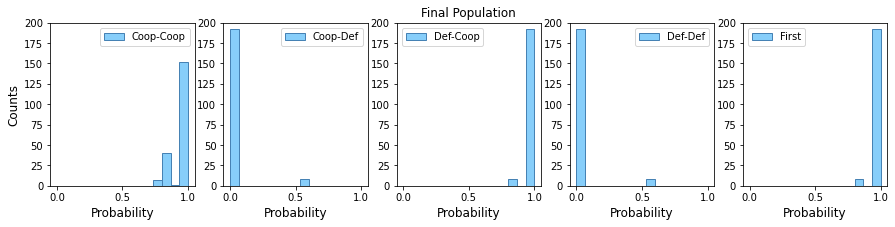

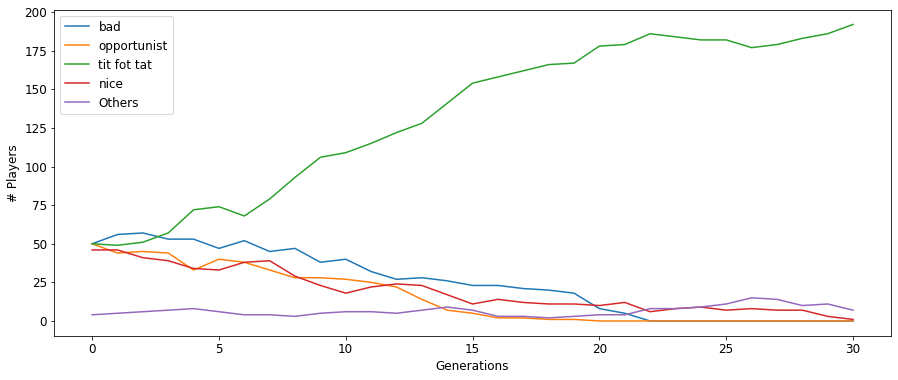

In [65]:
ylim = 200

fig3_a, axs3a = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))


axs3a[0].hist(result_peak[:,0], label='Coop-Coop', range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs3a[0].set_ylim((0, ylim))
axs3a[0].set_ylabel('Counts',fontsize=12)
axs3a[0].set_xlabel('Probability',fontsize=12)
axs3a[1].hist(result_peak[:,1], label='Coop-Def', range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs3a[1].set_ylim((0, ylim))
axs3a[1].set_xlabel('Probability',fontsize=12)
axs3a[2].hist(result_peak[:,2], label='Def-Coop', range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs3a[2].set_ylim((0, ylim))
axs3a[2].set_xlabel('Probability',fontsize=12)
axs3a[2].set_title('Final Population',fontsize=12)
axs3a[3].hist(result_peak[:,1], label='Def-Def' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs3a[3].set_ylim((0, ylim))
axs3a[3].set_xlabel('Probability',fontsize=12)
axs3a[4].hist(result_peak[:,2], label='First' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs3a[4].set_ylim((0, ylim))
axs3a[4].set_xlabel('Probability',fontsize=12)
axs3a[0].legend()
axs3a[1].legend()
axs3a[2].legend()
axs3a[3].legend()
axs3a[4].legend()


fig3_b, axs3_b = plt.subplots(figsize = (15,6))

for i, nome in zip(range(len(distr_peak_init)), characters_range_peak.keys()):
    axs3_b.plot(np.arange(31), np.array(r_distributions_peak).T[i], label=nome)
axs3_b.plot(np.arange(31),np.array(r_distributions_peak).T[4], label = 'Others')

axs3_b.set_xlabel('Generations',fontsize=12)
axs3_b.set_ylabel('# Players',fontsize=12)
axs3_b.tick_params(labelsize=12)
axs3_b.legend(fontsize = 12)

plt.show()

**Comment on the result.** With a more pronounced _tit-for-tat_ category we observe again how it results to be the overall winning strategy, independetly from the variety of the other players. This finds confirmation in the work of Axelrod of 1981 [Axelrod; Hamilton, 1981], where he showed how the _tit-for-tat_ strategy took over other strategies, independently of the intial population.

In [49]:
n_rounds = 10
# Definition of more peaked strategy ranges
characters_range_peak = {'bad':np.array([0.2,0.2,0.2,0.2,0.2]), 
                         'opportunist':np.array([0.8,0.2,0.2,0.2,0.2]),
                         'tit fot tat':np.array([1,0,1,0,1]),
                         'nice':np.array([0.8,0.8,0.8,0.8,0.8])}

distr_peak_init = [50,50,50,50]

players_peak_hmut, _ = create_pop_ranges(characters_range_peak, distr_peak_init)

In [50]:
result_peak_hmut, r_distributions_peak_hmut = Evolution_cont(players_peak_hmut, n_rounds, payoff, 30, True, 0.1)

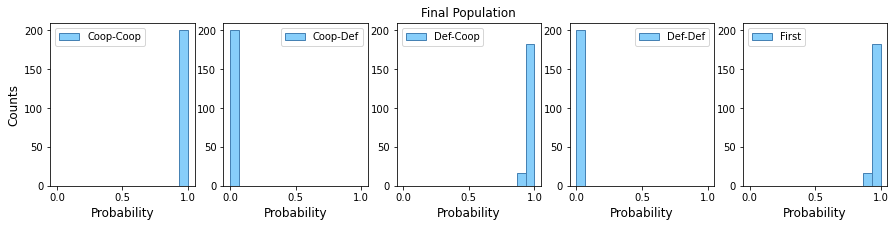

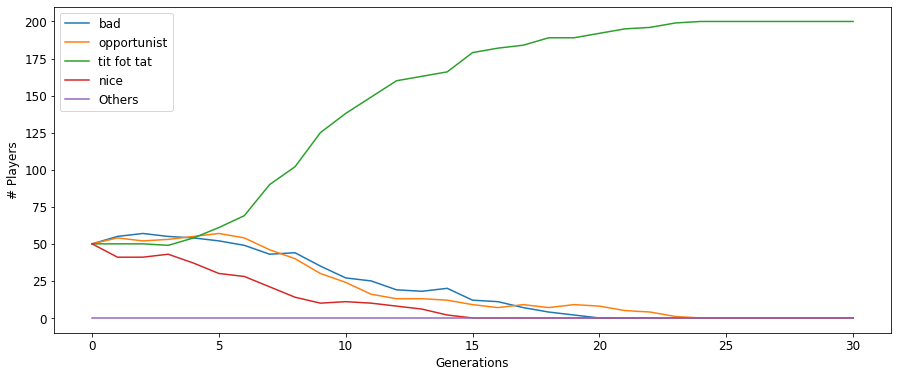

In [57]:
ylim = 210

fig3_a, axs3a = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))


axs3a[0].hist(result_peak_hmut[:,0], label='Coop-Coop', range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs3a[0].set_ylim((0, ylim))
axs3a[0].set_ylabel('Counts',fontsize=12)
axs3a[0].set_xlabel('Probability',fontsize=12)
axs3a[1].hist(result_peak_hmut[:,1], label='Coop-Def', range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs3a[1].set_ylim((0, ylim))
axs3a[1].set_xlabel('Probability',fontsize=12)
axs3a[2].hist(result_peak_hmut[:,2], label='Def-Coop', range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs3a[2].set_ylim((0, ylim))
axs3a[2].set_xlabel('Probability',fontsize=12)
axs3a[2].set_title('Final Population',fontsize=12)
axs3a[3].hist(result_peak_hmut[:,1], label='Def-Def' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs3a[3].set_ylim((0, ylim))
axs3a[3].set_xlabel('Probability',fontsize=12)
axs3a[4].hist(result_peak_hmut[:,2], label='First' , range = (0,1), bins = 15, color = 'lightskyblue', edgecolor='steelblue')
axs3a[4].set_ylim((0, ylim))
axs3a[4].set_xlabel('Probability',fontsize=12)
axs3a[0].legend()
axs3a[1].legend()
axs3a[2].legend()
axs3a[3].legend()
axs3a[4].legend()


fig3_b, axs3_b = plt.subplots(figsize = (15,6))

for i, nome in zip(range(len(distr_peak_init)), characters_range_peak.keys()):
    axs3_b.plot(np.arange(31), np.array(r_distributions_peak_hmut).T[i], label=nome)
axs3_b.plot(np.arange(31),np.array(r_distributions_peak_hmut).T[4], label = 'Others')

axs3_b.set_xlabel('Generations',fontsize=12)
axs3_b.set_ylabel('# Players',fontsize=12)
axs3_b.tick_params(labelsize=12)
axs3_b.legend(fontsize = 12)

plt.show()

**Comment on the result.** Even in this case with a higher mutation factor we observe that strategies out of the main categories are not likely to compete effectively against the more logical ones. We observe how _tit-for-tat_ remains the undiscussed winner also with a more pronounced mutation effect.

# Conclusions
In this project we have shown the results of simulations of Iterated Prisoner's Dilemma.

First of all we observed that in a single match bad players tend to overwhelm all the others and that the trand of a match is roughly linear for both involved players.

Then when considering a round-robin scheduled tournament on a larger population with multiple copies of the same strategies the result strongly depend on such population. Moreover we observed that tit-fotr-tat acts as stabilizer both holding bad players and preserving nice players.

When iterating such a tournament so that at the end of each one population is updated proportionally to the obtained scores the tit-for-tat population usually increases leading to the extinction of the other strategies.
In particular we have seen that altruism and adaptability are rewarded in the long term.

Lastly when leaving precise categories and studying the behaviour of more heterogeneous populations we see that the emerging strategy appears to be different from the ones that have been considered up to this point, namely we called it _Opportunist_. 
Adding a mutation, however, rewards less this type of player in favour of a more evil or more  tit-for-tat-like player, and in general leads to less accurate results.
Nevertheless when forcing the system into four more specific ranges of behaviours the tit-for-tat always emerges against all the others, even in case of high degree of mutation.

In conclusion we may state that  an "_eye for an eye_" strategy overcomes an  _"act in the way you wish others to act"_ strategy.

<img src="Kant.jpg" alt="Testo alternativo" width="500"/>